# Analyse Immobilière Madrid - Sélection des Variables

**Objectif :** Analyser et sélectionner les meilleures caractéristiques pour prédire le prix de l'immobilier à Madrid

**Approche :**
1. Explorer les données et diviser par type de bien (appartements vs maisons)
2. Analyser chaque variable individuellement
3. Sélectionner les variables les plus importantes
4. Valider les choix avec des méthodes statistiques

---

##  1. Import

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

# Configuration pour de beaux graphiques
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print("Bibliothèques importées avec succès !")

Bibliothèques importées avec succès !


## 2. Chargement des Données

In [18]:

df = pd.read_csv("../data_model/houses_madrid_cleaned.csv")
print(f"Dataset chargé : {df.shape[0]:,} lignes × {df.shape[1]} colonnes")
df.head()

Dataset chargé : 21,742 lignes × 37 colonnes


,sq_mt_built,sq_mt_useful,n_rooms,n_bathrooms,n_floors,sq_mt_allotment,floor,is_floor_under,rent_price,buy_price,buy_price_by_area,is_renewal_needed,is_new_development,built_year,has_central_heating,has_individual_heating,has_ac,has_fitted_wardrobes,has_lift,is_exterior,has_garden,has_pool,has_terrace,has_balcony,has_storage_room,is_accessible,has_green_zones,energy_certificate,has_parking,is_parking_included_in_price,parking_price,is_orientation_north,is_orientation_west,is_orientation_south,is_orientation_east,product,neighborhood
0,64.0,60.0,2,1.0,NaN,NaN,3,0.0,471,85000,1328,0,False,1960.0,NaN,NaN,1,0,0.0,1.0,0,0,0,0,0,0,0,NaN,0,NaN,NaN,0.0,1.0,0.0,0.0,piso,135
1,70.0,NaN,3,1.0,NaN,NaN,4,0.0,666,129900,1856,1,False,NaN,NaN,NaN,0,1,1.0,1.0,0,0,1,0,0,0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,piso,132
2,94.0,54.0,2,2.0,NaN,NaN,1,0.0,722,144247,1535,0,False,NaN,0.0,1.0,0,1,1.0,1.0,0,0,0,0,1,0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,piso,134
3,64.0,NaN,2,1.0,NaN,NaN,bajo,1.0,583,109900,1717,0,False,1955.0,NaN,NaN,0,0,1.0,1.0,0,0,0,0,1,1,0,NaN,0,NaN,NaN,0.0,0.0,1.0,0.0,piso,134
4,108.0,90.0,2,2.0,NaN,NaN,4,0.0,1094,260000,2407,0,False,2003.0,NaN,NaN,1,1,1.0,1.0,0,1,0,0,1,0,1,NaN,1,1.0,0.0,1.0,1.0,1.0,1.0,piso,133


In [19]:

print(" Informations générales :")
print(df.info())
print(f"• Types de données :")
print(df.dtypes.value_counts())
print(f"\n• Valeurs manquantes :")
manquante = df.isnull().sum().sort_values(ascending=False)
print(manquante[manquante > 0].head())

 Informations générales :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21742 entries, 0 to 21741
Data columns (total 37 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   sq_mt_built                   21616 non-null  float64
 1   sq_mt_useful                  8228 non-null   float64
 2   n_rooms                       21742 non-null  int64  
 3   n_bathrooms                   21726 non-null  float64
 4   n_floors                      1437 non-null   float64
 5   sq_mt_allotment               1432 non-null   float64
 6   floor                         19135 non-null  object 
 7   is_floor_under                20572 non-null  float64
 8   rent_price                    21742 non-null  int64  
 9   buy_price                     21742 non-null  int64  
 10  buy_price_by_area             21742 non-null  int64  
 11  is_renewal_needed             21742 non-null  int64  
 12  is_new_development            2075

In [20]:
# Transformation de la colonne "floor" en valeurs numériques

print("TRANSFORMATION DE LA COLONNE FLOOR")
print("="*40)

# Voir les valeurs actuelles
print("Valeurs uniques dans 'floor':")
print(df['floor'].value_counts())

# Créer un mapping pour traduire les étages espagnols en chiffres
floor_mapping = {
    # Étages normaux (restent tels quels)
    '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9,
    
    # Rez-de-chaussée
    'bajo': 0,
    
    # Mezzanines
    'entreplanta': 0.5,
    'entreplanta exterior': 0.5,
    'entreplanta interior': 0.5,
    
    # Demi sous-sols
    'semi-sotano': -0.5,
    'semi-sotano exterior': -0.5,
    'semi-sotano interior': -0.5,
    
    # Sous-sols
    'sotano': -1,
    'sotano exterior': -1,
    'sotano interior': -1
}

print(f"\nMapping créé avec {len(floor_mapping)} correspondances:")
for original, nouveau in floor_mapping.items():
    print(f"  '{original}' → {nouveau}")

# Appliquer la transformation
df['floor_numeric'] = df['floor'].map(floor_mapping)

# Gérer les valeurs non mappées (les convertir en numérique si possible)
mask_nan = df['floor_numeric'].isna()
valeurs_non_mappees = df.loc[mask_nan, 'floor'].unique()

print(f"\nValeurs non mappées: {valeurs_non_mappees}")

# Essayer de convertir directement les valeurs restantes en numérique
for val in valeurs_non_mappees:
    if pd.notna(val):
        try:
            # Essayer de convertir directement
            numeric_val = float(val)
            df.loc[df['floor'] == val, 'floor_numeric'] = numeric_val
            print(f"  '{val}' → {numeric_val} (conversion directe)")
        except:
            # Sinon mettre 0 par défaut
            df.loc[df['floor'] == val, 'floor_numeric'] = 0
            print(f"  '{val}' → 0 (défaut)")

# Vérifier le résultat
print(f"\nRésultat de la transformation:")
print(f"Valeurs manquantes dans floor_numeric: {df['floor_numeric'].isna().sum()}")
print(f"Nouvelle distribution:")
print(df['floor_numeric'].value_counts().sort_index())

# Remplacer l'ancienne colonne
df['floor'] = df['floor_numeric']

print("\nTransformation terminée : colonne 'floor' mise à jour")

TRANSFORMATION DE LA COLONNE FLOOR
Valeurs uniques dans 'floor':
floor
1                       4440
2                       3546
3                       3001
4                       2323
bajo                    2144
5                       1310
6                        913
7                        556
8                        326
entreplanta exterior     236
9                        181
semi-sotano exterior      55
semi-sotano interior      36
entreplanta interior      32
sotano interior           23
sotano                     5
sotano exterior            4
entreplanta                3
semi-sotano                1
Name: count, dtype: int64

Mapping créé avec 19 correspondances:
  '1' → 1
  '2' → 2
  '3' → 3
  '4' → 4
  '5' → 5
  '6' → 6
  '7' → 7
  '8' → 8
  '9' → 9
  'bajo' → 0
  'entreplanta' → 0.5
  'entreplanta exterior' → 0.5
  'entreplanta interior' → 0.5
  'semi-sotano' → -0.5
  'semi-sotano exterior' → -0.5
  'semi-sotano interior' → -0.5
  'sotano' → -1
  'sotano exterior' → -

In [21]:
# Nettoyer les colonnes avec trop de valeurs manquantes (>70%)

print("NETTOYAGE DES VALEURS MANQUANTES")
print("="*50)

# 1. Analyser le pourcentage de valeurs manquantes par colonne
print("Analyse des valeurs manquantes:")
valeurs_manquantes = df.isnull().sum()
pourcentages_na = (valeurs_manquantes / len(df) * 100).round(2)

# Créer un résumé des colonnes avec des NA
resume_na = pd.DataFrame({
    'Colonne': valeurs_manquantes.index,
    'Nb_NA': valeurs_manquantes.values,
    'Pourcentage_NA': pourcentages_na.values
})

# Trier par pourcentage décroissant
resume_na = resume_na.sort_values('Pourcentage_NA', ascending=False)

print(f"\nTop 10 des colonnes avec le plus de valeurs manquantes:")
print(resume_na.head(10).to_string(index=False))

# 2. Identifier les colonnes à supprimer (>60% de NA = moins de 40% de valeurs)
seuil_suppression = 40
colonnes_a_supprimer = resume_na[resume_na['Pourcentage_NA'] > seuil_suppression]['Colonne'].tolist()

print(f"\nColonnes à supprimer (>{seuil_suppression}% de NA = moins de 40% de valeurs):")
if colonnes_a_supprimer:
    for col in colonnes_a_supprimer:
        pct = resume_na[resume_na['Colonne'] == col]['Pourcentage_NA'].iloc[0]
        valeurs_utiles = 100 - pct
        print(f"  • {col}: {pct:.1f}% NA (seulement {valeurs_utiles:.1f}% de valeurs utiles)")
else:
    print(f"  ✓ Aucune colonne n'a plus de {seuil_suppression}% de valeurs manquantes")

# 3. Supprimer les colonnes problématiques
taille_avant = df.shape
if colonnes_a_supprimer:
    df_clean = df.drop(columns=colonnes_a_supprimer)
    print(f"\n{len(colonnes_a_supprimer)} colonnes supprimées")
else:
    df_clean = df.copy()
    print(f"\nAucune colonne supprimée")


# 5. Résumé final
taille_apres = df_clean.shape
print(f"\nRÉSUMÉ DU NETTOYAGE:")
print(f"  Taille avant: {taille_avant[0]:,} lignes × {taille_avant[1]} colonnes")
print(f"  Taille après: {taille_apres[0]:,} lignes × {taille_apres[1]} colonnes")
print(f"  Colonnes supprimées: {taille_avant[1] - taille_apres[1]}")
print(f"  Valeurs NA restantes: {df_clean.isnull().sum().sum()}")

# Mettre à jour le dataframe principal
df = df_clean.copy()
print(f"\n✅ Dataset nettoyé et mis à jour!")

NETTOYAGE DES VALEURS MANQUANTES
Analyse des valeurs manquantes:

Top 10 des colonnes avec le plus de valeurs manquantes:
                     Colonne  Nb_NA  Pourcentage_NA
          energy_certificate  21742          100.00
             sq_mt_allotment  20310           93.41
                    n_floors  20305           93.39
               parking_price  14023           64.50
is_parking_included_in_price  14023           64.50
                sq_mt_useful  13514           62.16
                  built_year  11743           54.01
         is_orientation_east  10384           47.76
        is_orientation_south  10384           47.76
         is_orientation_west  10384           47.76

Colonnes à supprimer (>40% de NA = moins de 40% de valeurs):
  • energy_certificate: 100.0% NA (seulement 0.0% de valeurs utiles)
  • sq_mt_allotment: 93.4% NA (seulement 6.6% de valeurs utiles)
  • n_floors: 93.4% NA (seulement 6.6% de valeurs utiles)
  • parking_price: 64.5% NA (seulement 35.5% de vale

## 🏠 3. Division par Type de Bien

**Hypothèse :** Les appartements et les maisons ont des caractéristiques différentes qui influencent leur prix.

**Objectif :** Séparer les données pour analyser chaque type séparément.

TYPES DE BIENS DISPONIBLES
Distribution des types :
   • piso            : 17,705 (81.4%)
   • atico           :  1,032 ( 4.7%)
   • casa o chalet   :    977 ( 4.5%)
   • duplex          :    676 ( 3.1%)
   • chalet adosado  :    527 ( 2.4%)
   • chalet pareado  :    434 ( 2.0%)
   • estudio         :    388 ( 1.8%)
   • finca           :      2 ( 0.0%)
   • casa            :      1 ( 0.0%)


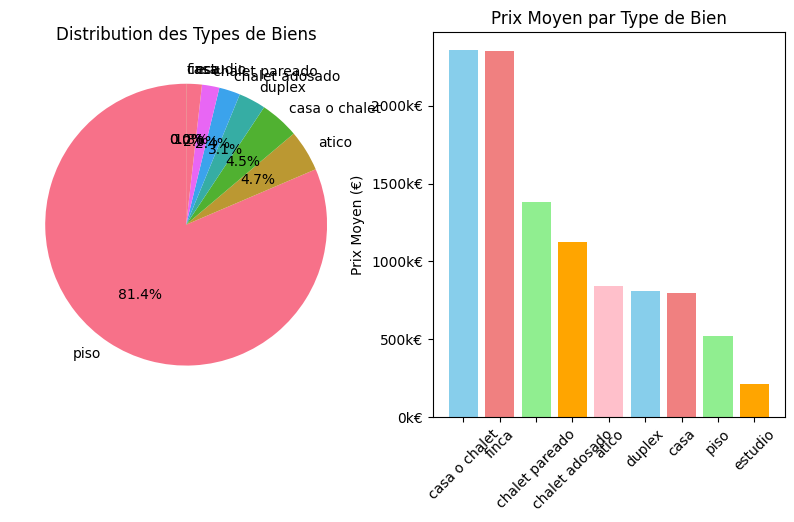

In [22]:
print("TYPES DE BIENS DISPONIBLES")
print("="*50)

# Distribution des types de produits
product_counts = df['product'].value_counts()
print("Distribution des types :")
for product_type, count in product_counts.items():
    pct = count / len(df) * 100
    print(f"   • {product_type:<15} : {count:>6,} ({pct:4.1f}%)")

# Graphique en secteurs
plt.figure(figsize=(10, 5))

# Graphique 1 : Distribution des types
plt.subplot(1, 2, 1)
plt.pie(product_counts.values, labels=product_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution des Types de Biens')

# Graphique 2 : Prix moyen par type
plt.subplot(1, 2, 2)
prix_moyen = df.groupby('product')['buy_price'].mean().sort_values(ascending=False)
plt.bar(prix_moyen.index, prix_moyen.values, color=['skyblue', 'lightcoral', 'lightgreen', 'orange', 'pink'][:len(prix_moyen)])
plt.title('Prix Moyen par Type de Bien')
plt.ylabel('Prix Moyen (€)')
plt.xticks(rotation=45)

# Formatage des prix en milliers d'euros
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1000:.0f}k€'))

In [23]:
# Simplification : Regrouper en 2 catégories principales
print("\nREGROUPEMENT EN 2 CATÉGORIES")
print("="*50)

# Créer une classification simple : Appartements vs Maisons
def fr(product_type):
    appartements = ['piso', 'atico', 'estudio']
    if product_type in appartements:
        return 'Appartement'
    else:
        return 'Maison'

# Appliquer la classification
df['type_simple'] = df['product'].apply(fr)

# Statistiques des 2 catégories
stats_type = df['type_simple'].value_counts()
print("Nouvelle classification :")
for type_bien, count in stats_type.items():
    pct = count / len(df) * 100
    prix_moyen = df[df['type_simple'] == type_bien]['buy_price'].mean()
    print(f"   • {type_bien:<12} : {count:>6,} ({pct:4.1f}%) - Prix moyen : {prix_moyen:,.0f} €")

# Créer les sous-datasets
df_appartements = df[df['type_simple'] == 'Appartement'].copy()
df_maisons = df[df['type_simple'] == 'Maison'].copy()

print(f"\nDatasets créés :")
print(f"   • Appartements : {len(df_appartements):,} biens")
print(f"   • Maisons      : {len(df_maisons):,} biens")


REGROUPEMENT EN 2 CATÉGORIES
Nouvelle classification :
   • Appartement  : 19,125 (88.0%) - Prix moyen : 531,625 €
   • Maison       :  2,617 (12.0%) - Prix moyen : 1,546,121 €

Datasets créés :
   • Appartements : 19,125 biens
   • Maisons      : 2,617 biens


In [24]:
## 🔬 4. HYPOTHÈSES PAR TYPE DE BIEN

print("FORMULATION D'HYPOTHÈSES PAR TYPE DE BIEN")
print("="*60)

print("\n HYPOTHÈSES POUR LES APPARTEMENTS :")
print("-" * 40)
hypotheses_appartements = {
    'H1': "La superficie est le facteur #1 pour le prix",
    'H2': "Le nombre de chambres influence fortement le prix", 
    'H3': "La présence d'ascenseur ajoute de la valeur",
    'H4': "L'étage influence le prix (plus haut = plus cher)",
    'H5': "La présence de balcon/terrasse augmente le prix"
}

for hyp, description in hypotheses_appartements.items():
    print(f"   {hyp}: {description}")

print("\n HYPOTHÈSES POUR LES MAISONS :")
print("-" * 40)
hypotheses_maisons = {
    'H1': "La superficie totale est cruciale",
    'H2': "Le nombre de chambres et salles de bain est plus important",
    'H3': "La présence de jardin a un gros impact",
    'H4': "La présence d'une piscine impacte le prix",
    'H5': "Le parking/garage est essentiel"
}

for hyp, description in hypotheses_maisons.items():
    print(f"   {hyp}: {description}")

print(f"\n {len(hypotheses_appartements)} hypothèses formulées pour les appartements")
print(f" {len(hypotheses_maisons)} hypothèses formulées pour les maisons")

FORMULATION D'HYPOTHÈSES PAR TYPE DE BIEN

 HYPOTHÈSES POUR LES APPARTEMENTS :
----------------------------------------
   H1: La superficie est le facteur #1 pour le prix
   H2: Le nombre de chambres influence fortement le prix
   H3: La présence d'ascenseur ajoute de la valeur
   H4: L'étage influence le prix (plus haut = plus cher)
   H5: La présence de balcon/terrasse augmente le prix

 HYPOTHÈSES POUR LES MAISONS :
----------------------------------------
   H1: La superficie totale est cruciale
   H2: Le nombre de chambres et salles de bain est plus important
   H3: La présence de jardin a un gros impact
   H4: La présence d'une piscine impacte le prix
   H5: Le parking/garage est essentiel

 5 hypothèses formulées pour les appartements
 5 hypothèses formulées pour les maisons


🔍 DÉTECTION DES OUTLIERS - APPROCHE MÉTIER

🏠 TRAITEMENT DES APPARTEMENTS

📊 ANALYSE OUTLIERS - APPARTEMENTS
----------------------------------------
Nombre initial de biens: 19,125
Prix < 30,000€ ou > 3,000,000€: 164
Superficie < 15m² ou > 800m²: 4
Prix/m² < 800€ ou > 12000€: 59

📈 RÉSULTATS:
  Biens gardés: 18,923 (98.9%)
  Outliers supprimés: 202 (1.1%)


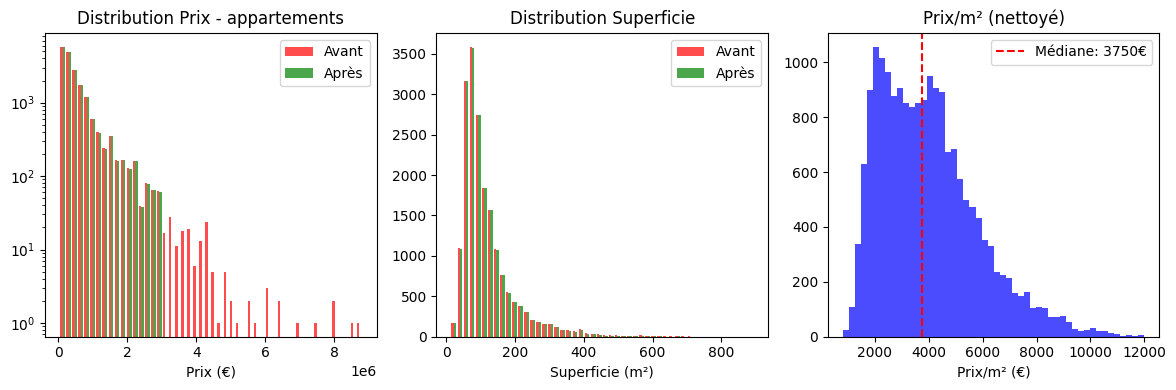


🏡 TRAITEMENT DES MAISONS

📊 ANALYSE OUTLIERS - MAISONS
----------------------------------------
Nombre initial de biens: 2,617
Prix < 30,000€ ou > 3,000,000€: 270
Superficie < 40m² ou > 2000m²: 136
Prix/m² < 800€ ou > 12000€: 128

📈 RÉSULTATS:
  Biens gardés: 2,269 (86.7%)
  Outliers supprimés: 348 (13.3%)


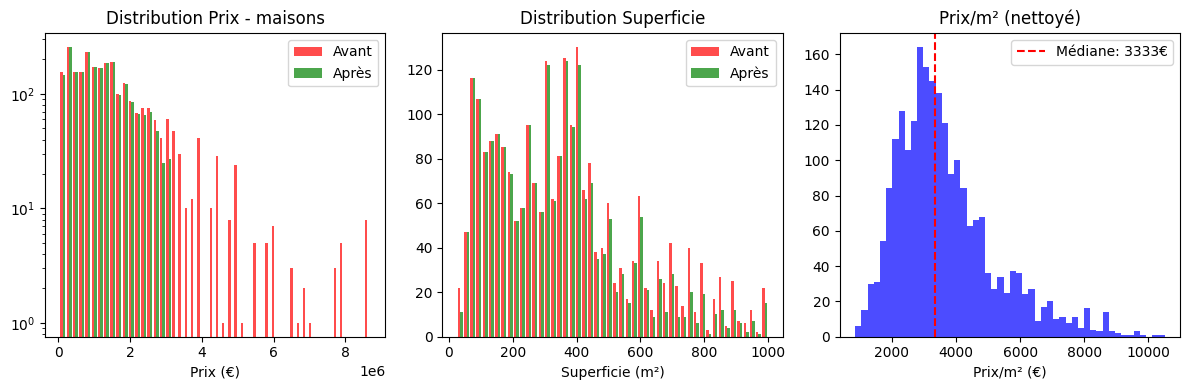


✅ NETTOYAGE TERMINÉ!
📊 Appartements: 18,923 biens
🏡 Maisons: 2,269 biens
📈 Total: 21,192 biens


In [25]:
# 4.5. Détection et traitement des outliers intelligents

print("🔍 DÉTECTION DES OUTLIERS - APPROCHE MÉTIER")
print("="*60)

# Fonction pour analyser les outliers
def analyser_outliers(df, nom_type):
    print(f"\n📊 ANALYSE OUTLIERS - {nom_type.upper()}")
    print("-" * 40)
    
    n_initial = len(df)
    print(f"Nombre initial de biens: {n_initial:,}")
    
    # 1. PRIX ABERRANTS (erreurs probables)
    prix_min_valide = 30000   # Minimum réaliste à Madrid
    prix_max_valide = 3000000  # Maximum raisonnable (non luxe extrême)
    
    mask_prix = (df['buy_price'] >= prix_min_valide) & (df['buy_price'] <= prix_max_valide)
    outliers_prix = df[~mask_prix]
    
    print(f"Prix < {prix_min_valide:,}€ ou > {prix_max_valide:,}€: {len(outliers_prix)}")
    
    # 2. SUPERFICIE IMPOSSIBLE
    if 'sq_mt_built' in df.columns:
        surf_min = 15 if nom_type == "appartements" else 40  # Min réaliste
        surf_max = 800 if nom_type == "appartements" else 2000
        
        mask_surf = (df['sq_mt_built'] >= surf_min) & (df['sq_mt_built'] <= surf_max)
        outliers_surf = df[~mask_surf]
        print(f"Superficie < {surf_min}m² ou > {surf_max}m²: {len(outliers_surf)}")
    else:
        mask_surf = True
        outliers_surf = pd.DataFrame()
    
    # 3. PRIX AU M² ABERRANT
    if 'sq_mt_built' in df.columns:
        df_temp = df.copy()
        df_temp['prix_m2'] = df_temp['buy_price'] / df_temp['sq_mt_built']
        
        prix_m2_min = 800   # Minimum réaliste Madrid
        prix_m2_max = 12000  # Maximum raisonnable
        
        mask_prix_m2 = (df_temp['prix_m2'] >= prix_m2_min) & (df_temp['prix_m2'] <= prix_m2_max)
        outliers_prix_m2 = df_temp[~mask_prix_m2]
        print(f"Prix/m² < {prix_m2_min}€ ou > {prix_m2_max}€: {len(outliers_prix_m2)}")
    else:
        mask_prix_m2 = True
        outliers_prix_m2 = pd.DataFrame()
    
    # 4. COMBINAISON DES FILTRES
    mask_final = mask_prix & mask_surf & mask_prix_m2
    df_clean = df[mask_final].copy()
    outliers_total = df[~mask_final]
    
    print(f"\n📈 RÉSULTATS:")
    print(f"  Biens gardés: {len(df_clean):,} ({len(df_clean)/n_initial*100:.1f}%)")
    print(f"  Outliers supprimés: {len(outliers_total):,} ({len(outliers_total)/n_initial*100:.1f}%)")
    
    # 5. VISUALISATION RAPIDE
    if len(outliers_total) > 0:
        plt.figure(figsize=(12, 4))
        
        # Prix avant/après
        plt.subplot(1, 3, 1)
        plt.hist([df['buy_price'], df_clean['buy_price']], 
                bins=50, alpha=0.7, label=['Avant', 'Après'], color=['red', 'green'])
        plt.xlabel('Prix (€)')
        plt.title(f'Distribution Prix - {nom_type}')
        plt.legend()
        plt.yscale('log')
        
        # Superficie avant/après
        if 'sq_mt_built' in df.columns:
            plt.subplot(1, 3, 2)
            plt.hist([df['sq_mt_built'], df_clean['sq_mt_built']], 
                    bins=50, alpha=0.7, label=['Avant', 'Après'], color=['red', 'green'])
            plt.xlabel('Superficie (m²)')
            plt.title('Distribution Superficie')
            plt.legend()
        
        # Prix/m² après nettoyage
        if 'sq_mt_built' in df_clean.columns:
            plt.subplot(1, 3, 3)
            prix_m2_clean = df_clean['buy_price'] / df_clean['sq_mt_built']
            plt.hist(prix_m2_clean, bins=50, alpha=0.7, color='blue')
            plt.xlabel('Prix/m² (€)')
            plt.title('Prix/m² (nettoyé)')
            plt.axvline(prix_m2_clean.median(), color='red', linestyle='--', 
                       label=f'Médiane: {prix_m2_clean.median():.0f}€')
            plt.legend()
        
        plt.tight_layout()
        plt.show()
    
    return df_clean

# APPLIQUER LE NETTOYAGE
print("\n🏠 TRAITEMENT DES APPARTEMENTS")
df_appartements_clean = analyser_outliers(df_appartements, "appartements")

print("\n🏡 TRAITEMENT DES MAISONS") 
df_maisons_clean = analyser_outliers(df_maisons, "maisons")

# MISE À JOUR DES DATASETS
df_appartements = df_appartements_clean.copy()
df_maisons = df_maisons_clean.copy()

print(f"\n✅ NETTOYAGE TERMINÉ!")
print(f"📊 Appartements: {len(df_appartements):,} biens")
print(f"🏡 Maisons: {len(df_maisons):,} biens")
print(f"📈 Total: {len(df_appartements) + len(df_maisons):,} biens") 

## 🔧 Commentaires sur les Filtres Appliqués

### **Logique des seuils choisis :**

**🏠 Prix :**
- **Minimum 30k€** : Élimine les erreurs de saisie (prix à 1€, 100€...)
- **Maximum 3M€** : Garde le luxe raisonnable, supprime les erreurs extrêmes

**📐 Superficie :**
- **Appartements** : 15m² min (studio) / 800m² max 
- **Maisons** : 40m² min (logique) / 2000m² max (manoirs exclus)

**💰 Prix/m² :**
- **800-12000€/m²** : Fourchette réaliste Madrid (périphérie → centre luxe)

### **Impact du nettoyage :**
✅ **Conservé** : Biens de luxe cohérents (penthouse 2M€ + 200m²)  
❌ **Supprimé** : Erreurs techniques (maison 5€, appartement 3m²)

**→ Données prêtes pour modélisation fiable !**

ANALYSE DES VARIABLES PRINCIPALES
Variables numériques sélectionnées (22):
   1. sq_mt_built
   2. n_rooms
   3. n_bathrooms
   4. floor
   5. is_floor_under
   6. is_renewal_needed
   7. has_central_heating
   8. has_individual_heating
   9. has_ac
  10. has_fitted_wardrobes
  11. has_lift
  12. is_exterior
  13. has_garden
  14. has_pool
  15. has_terrace
  16. has_balcony
  17. has_storage_room
  18. is_accessible
  19. has_green_zones
  20. has_parking
  21. neighborhood
  22. floor_numeric

Création d'une grille 8x3 (taille: 18x32)
  ✓ Graphique créé pour sq_mt_built
  ✓ Graphique créé pour n_rooms
  ✓ Graphique créé pour n_bathrooms
  ✓ Graphique créé pour floor
  ✓ Graphique créé pour is_floor_under
  ✓ Graphique créé pour is_renewal_needed
  ✓ Graphique créé pour has_central_heating
  ✓ Graphique créé pour has_individual_heating
  ✓ Graphique créé pour has_ac
  ✓ Graphique créé pour has_fitted_wardrobes
  ✓ Graphique créé pour has_lift
  ✓ Graphique créé pour is_exterior
  ✓ Gr

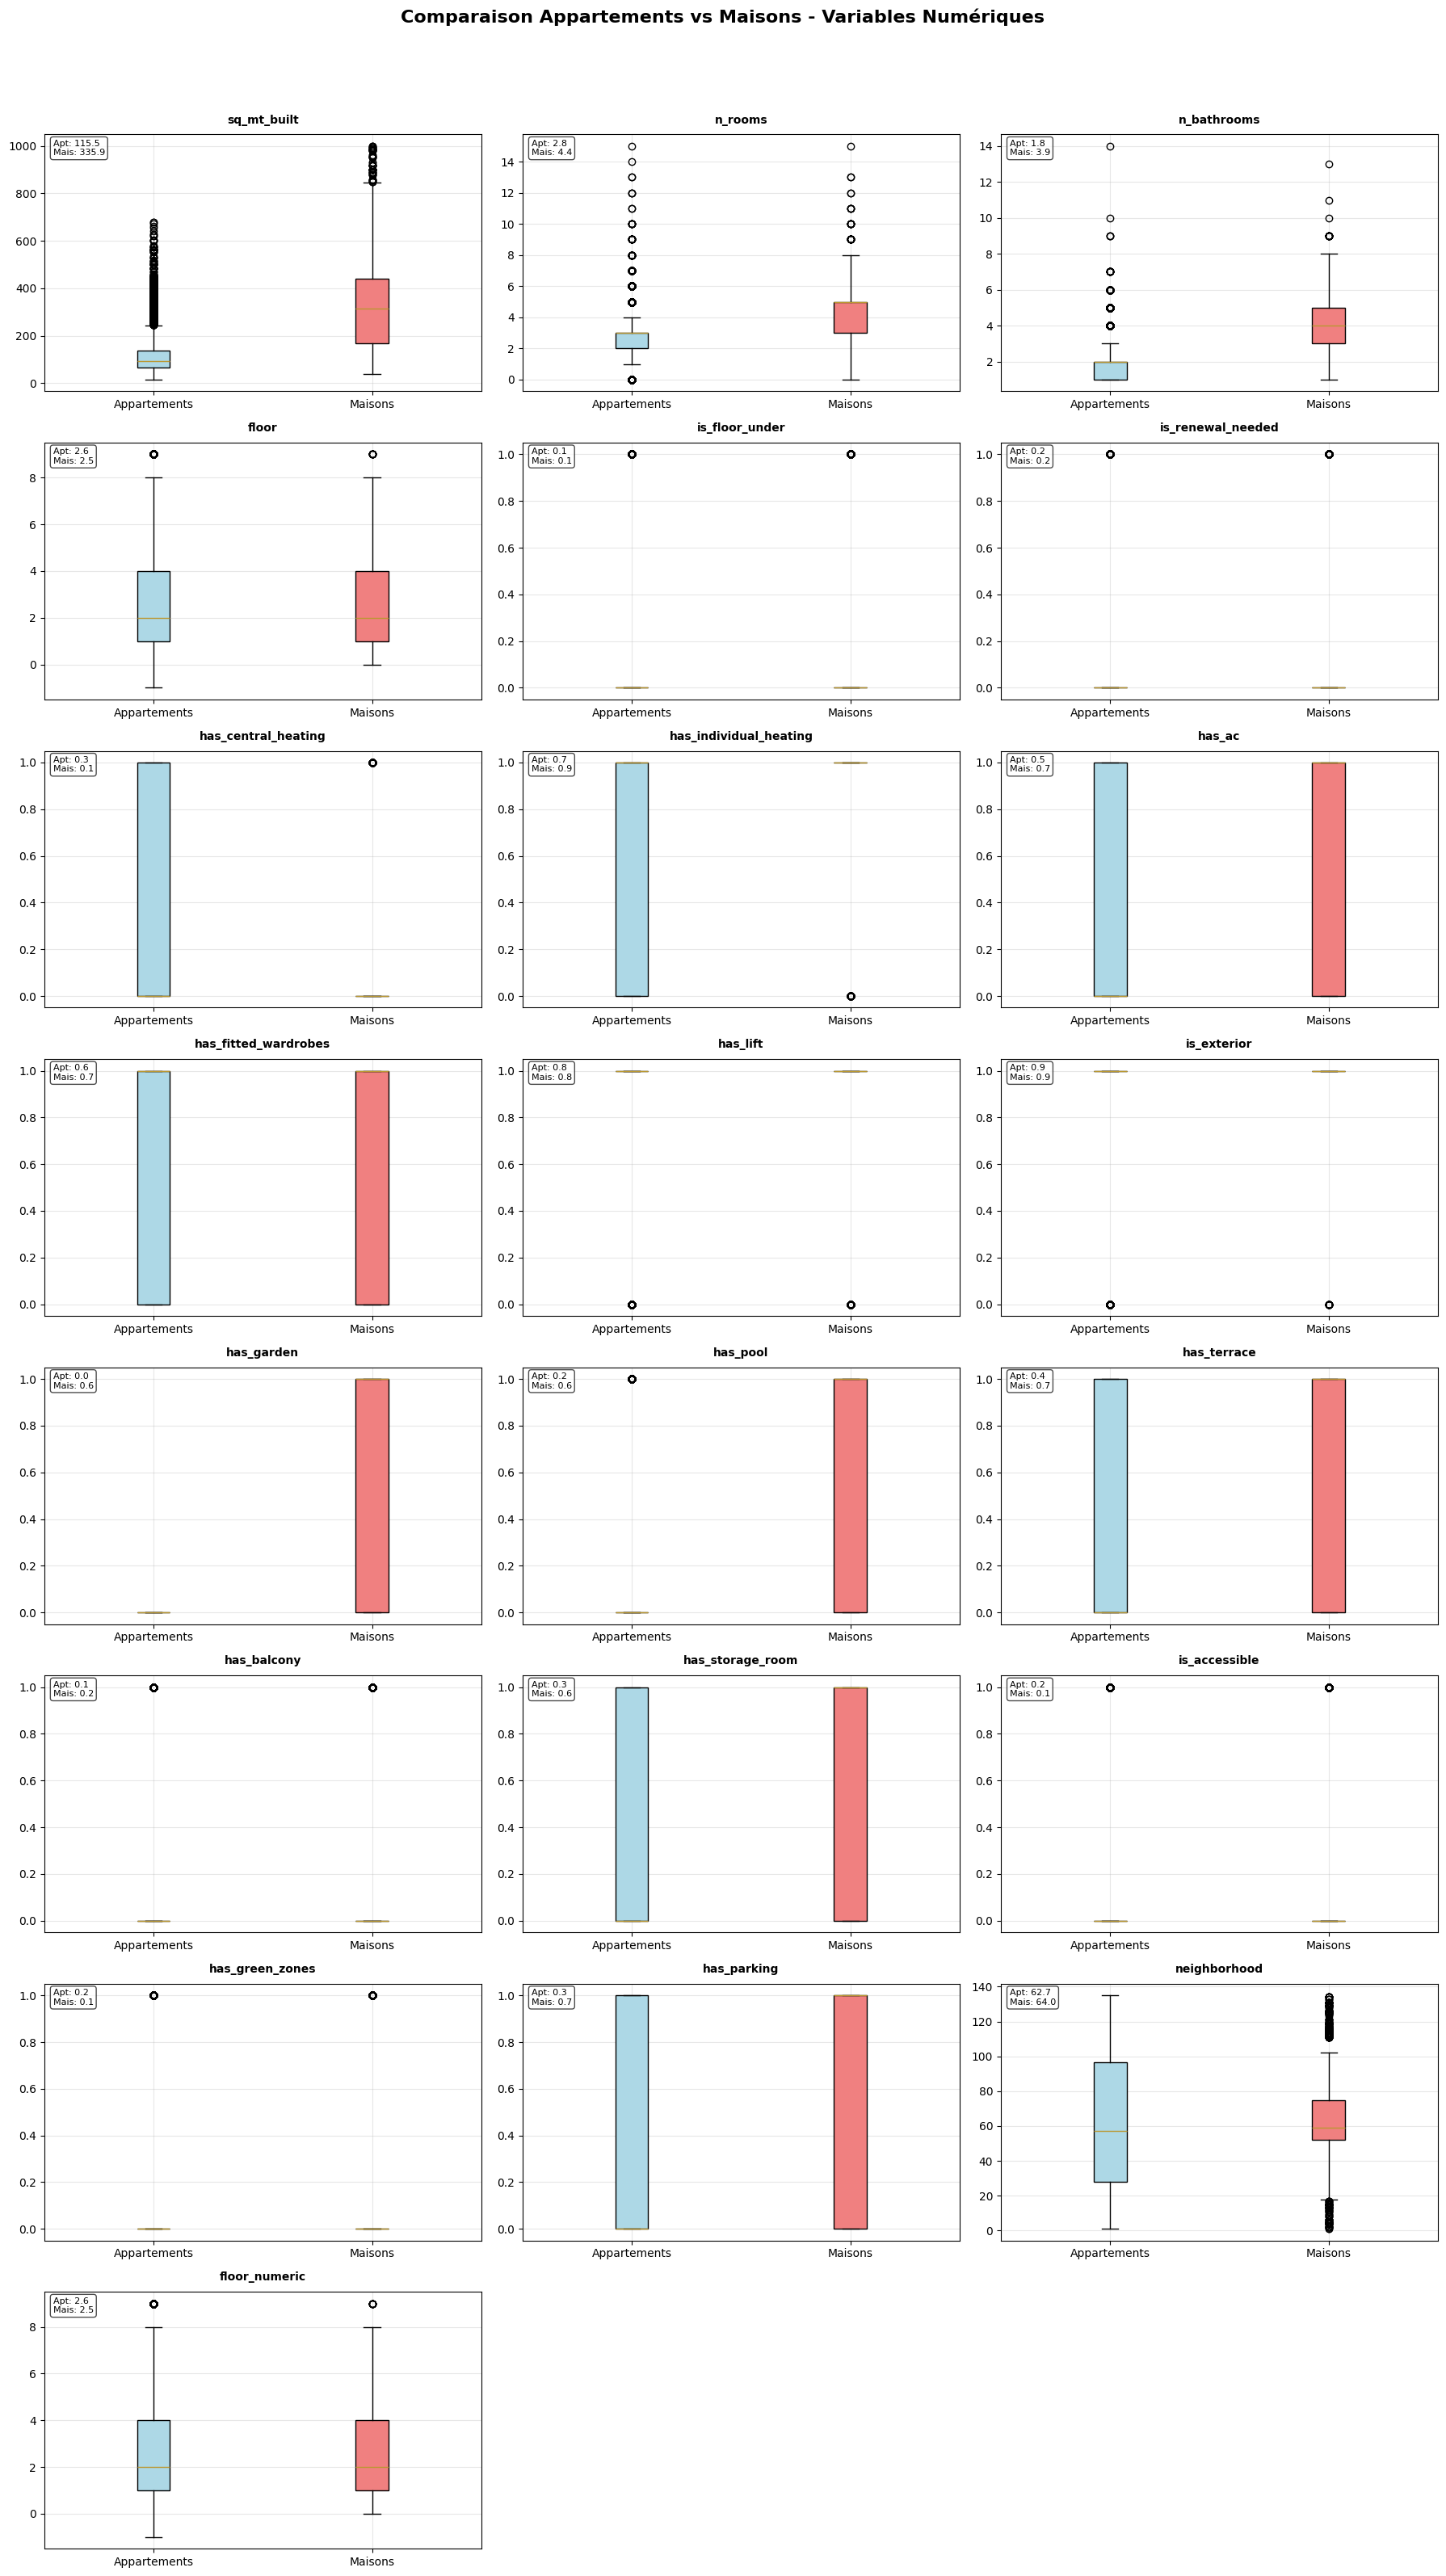


Analyse terminée pour 22 variables numériques


In [26]:
# 5. Analyse des variables importantes (corrigée et lisible)

print("ANALYSE DES VARIABLES PRINCIPALES")
print("="*50)

# Sélectionner seulement les variables numériques pertinentes
vars_numeriques = df.select_dtypes(include=[np.number]).columns.tolist()

# Exclure les colonnes d'identifiants et autres non pertinentes
vars_to_exclude = ['buy_price', 'rent_price', 'buy_price_by_area', 'parking_price']
vars_to_check = [var for var in vars_numeriques if var not in vars_to_exclude]

print(f"Variables numériques sélectionnées ({len(vars_to_check)}):")
for i, var in enumerate(vars_to_check, 1):
    print(f"  {i:2d}. {var}")

# Calculer la disposition optimale des sous-graphiques
n_vars = len(vars_to_check)
n_cols = 3  # 3 colonnes par ligne
n_rows = int(np.ceil(n_vars / n_cols))

# Ajuster la taille de la figure selon le nombre de variables
fig_height = max(10, n_rows * 4)  # Au moins 4 unités de hauteur par ligne
fig_width = 18  # Largeur fixe pour 3 colonnes

print(f"\nCréation d'une grille {n_rows}x{n_cols} (taille: {fig_width}x{fig_height})")

# Créer les graphiques avec une taille adaptée
fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, fig_height))
fig.suptitle('Comparaison Appartements vs Maisons - Variables Numériques', 
             fontsize=16, fontweight='bold', y=0.995)

# S'assurer que axes est toujours un array 2D
if n_rows == 1:
    axes = axes.reshape(1, -1)
elif n_cols == 1:
    axes = axes.reshape(-1, 1)

# Créer les graphiques
for i, var in enumerate(vars_to_check):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    
    try:
        # S'assurer que les données sont numériques
        data_apt = pd.to_numeric(df_appartements[var], errors='coerce').dropna()
        data_maisons = pd.to_numeric(df_maisons[var], errors='coerce').dropna()
        
        if len(data_apt) > 0 and len(data_maisons) > 0:
            # Créer le boxplot
            bp = ax.boxplot([data_apt.values, data_maisons.values], 
                           labels=['Appartements', 'Maisons'],
                           patch_artist=True)
            
            # Colorer
            bp['boxes'][0].set_facecolor('lightblue')
            bp['boxes'][1].set_facecolor('lightcoral')
            
            # Titre plus lisible
            ax.set_title(f'{var}', fontsize=10, fontweight='bold', pad=10)
            ax.grid(True, alpha=0.3)
            
            # Ajouter des statistiques basiques
            mean_apt = data_apt.mean()
            mean_maisons = data_maisons.mean()
            
            # Texte avec info
            ax.text(0.02, 0.98, f'Apt: {mean_apt:.1f}\nMais: {mean_maisons:.1f}', 
                   transform=ax.transAxes, verticalalignment='top', fontsize=8,
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
            
            print(f"  ✓ Graphique créé pour {var}")
            
        else:
            ax.text(0.5, 0.5, f'Pas de données\npour {var}', 
                   ha='center', va='center', transform=ax.transAxes,
                   fontsize=10, fontweight='bold')
            ax.set_title(f'{var} (Aucune donnée)', fontsize=10, color='red')
            print(f"  ✗ Pas de données pour {var}")
            
    except Exception as e:
        ax.text(0.5, 0.5, f'Erreur\n{var}\n{str(e)[:20]}', 
               ha='center', va='center', transform=ax.transAxes,
               fontsize=9, color='red')
        ax.set_title(f'{var} (Erreur)', fontsize=10, color='red')
        print(f"  ✗ Erreur avec {var}: {str(e)}")

# Masquer les sous-graphiques vides
for i in range(len(vars_to_check), n_rows * n_cols):
    row = i // n_cols
    col = i % n_cols
    axes[row, col].set_visible(False)

# Ajuster l'espacement pour une meilleure lisibilité
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Laisser de la place pour le titre
plt.show()

print(f"\nAnalyse terminée pour {len(vars_to_check)} variables numériques")

ANALYSE DU PRIX PAR RAPPORT AUX VARIABLES - APPARTEMENTS

1. STATISTIQUES DU PRIX DES APPARTEMENTS
----------------------------------------
Nombre d'appartements: 18,923
Prix moyen: 499,628 €
Prix médian: 330,000 €
Prix min: 42,000 €
Prix max: 3,000,000 €
Écart-type: 484,662 €

2. TOP 10 CORRÉLATIONS AVEC LE PRIX
----------------------------------------
Variables les plus corrélées au prix:
  sq_mt_built         : +0.865 (FORTE +)
  n_bathrooms         : +0.764 (FORTE +)
  buy_price_by_area   : +0.653 (FORTE +)
  rent_price          : -0.624 (FORTE -)
  n_rooms             : +0.520 (FORTE +)
  has_central_heating : +0.374 (FORTE +)
  has_individual_heating: -0.374 (FORTE -)
  has_lift            : +0.349 (FORTE +)
  has_parking         : +0.283 (MODÉRÉE +)
  has_storage_room    : +0.264 (MODÉRÉE +)

3. GRAPHIQUES PRIX vs TOUTES VARIABLES SIGNIFICATIVES
----------------------------------------
Visualisation de 10 variables avec corrélation > 0.2:
  • sq_mt_built: +0.865
  • n_bathrooms:

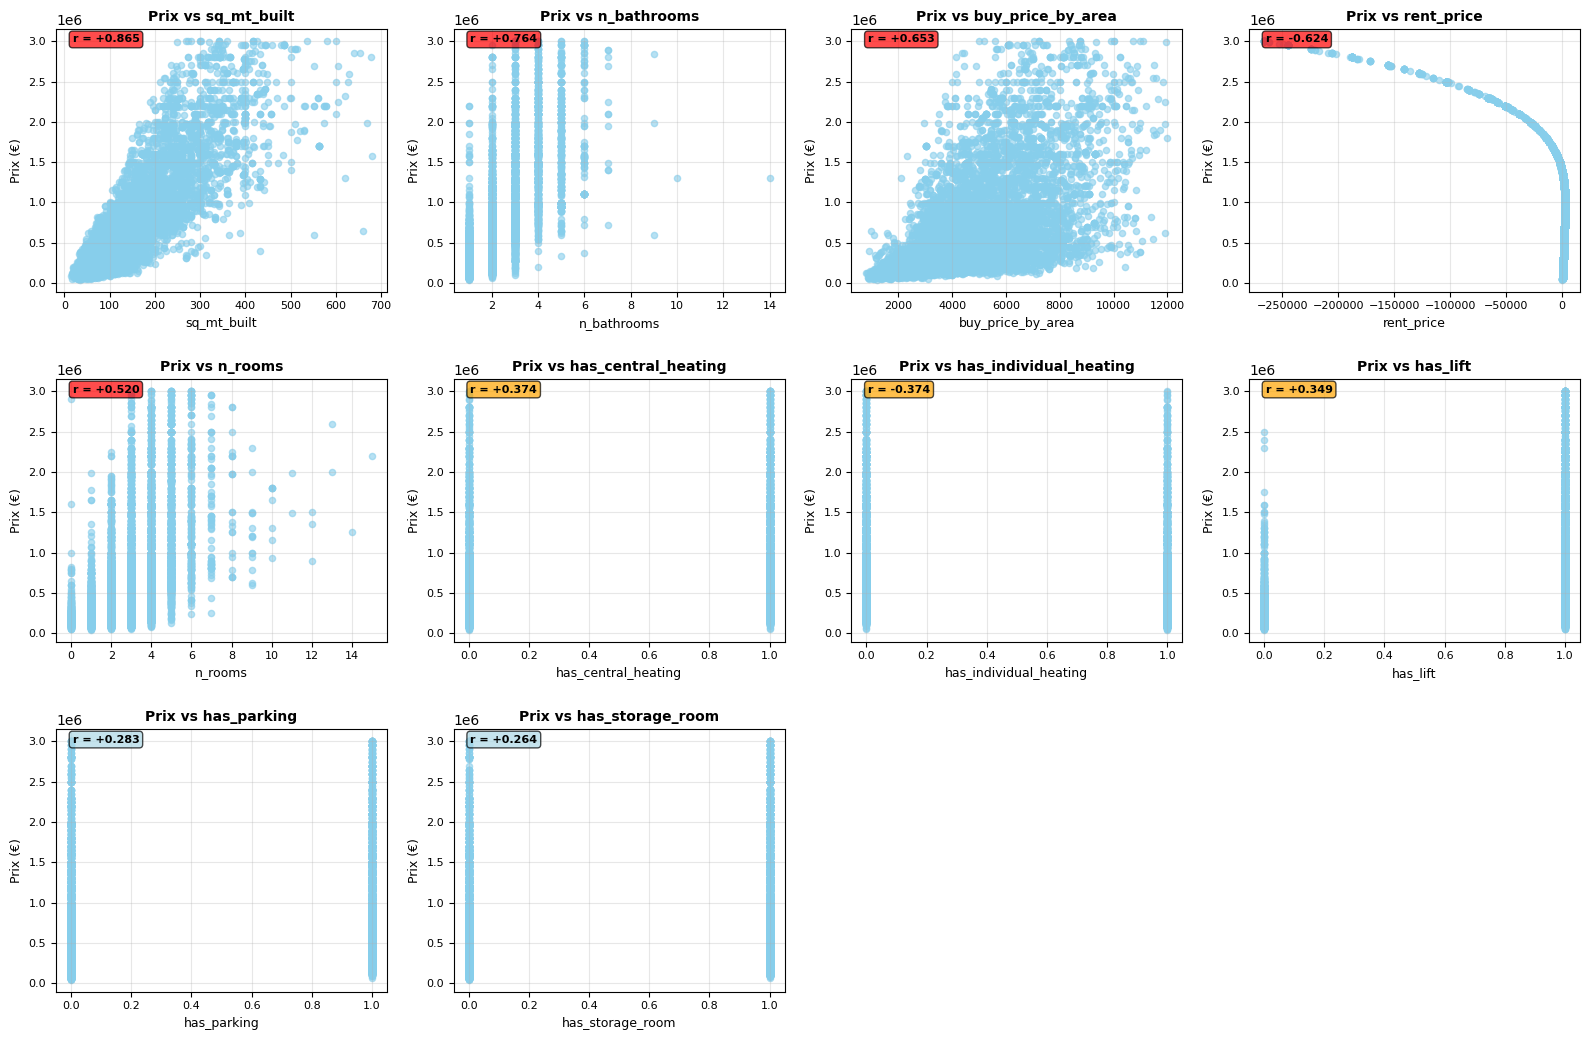


📊 TABLEAU RÉCAPITULATIF - 10 VARIABLES SIGNIFICATIVES:
----------------------------------------------------------------------
Variable                  Corrélation  Force           Type
----------------------------------------------------------------------
sq_mt_built               +0.865       TRÈS FORTE      POSITIVE
n_bathrooms               +0.764       TRÈS FORTE      POSITIVE
buy_price_by_area         +0.653       FORTE           POSITIVE
rent_price                -0.624       FORTE           NÉGATIVE
n_rooms                   +0.520       FORTE           POSITIVE
has_central_heating       +0.374       MODÉRÉE         POSITIVE
has_individual_heating    -0.374       MODÉRÉE         NÉGATIVE
has_lift                  +0.349       MODÉRÉE         POSITIVE
has_parking               +0.283       FAIBLE          POSITIVE
has_storage_room          +0.264       FAIBLE          POSITIVE

4. PRIX MOYEN PAR CATÉGORIES
----------------------------------------

Prix moyen par étage:

🔬 VALID

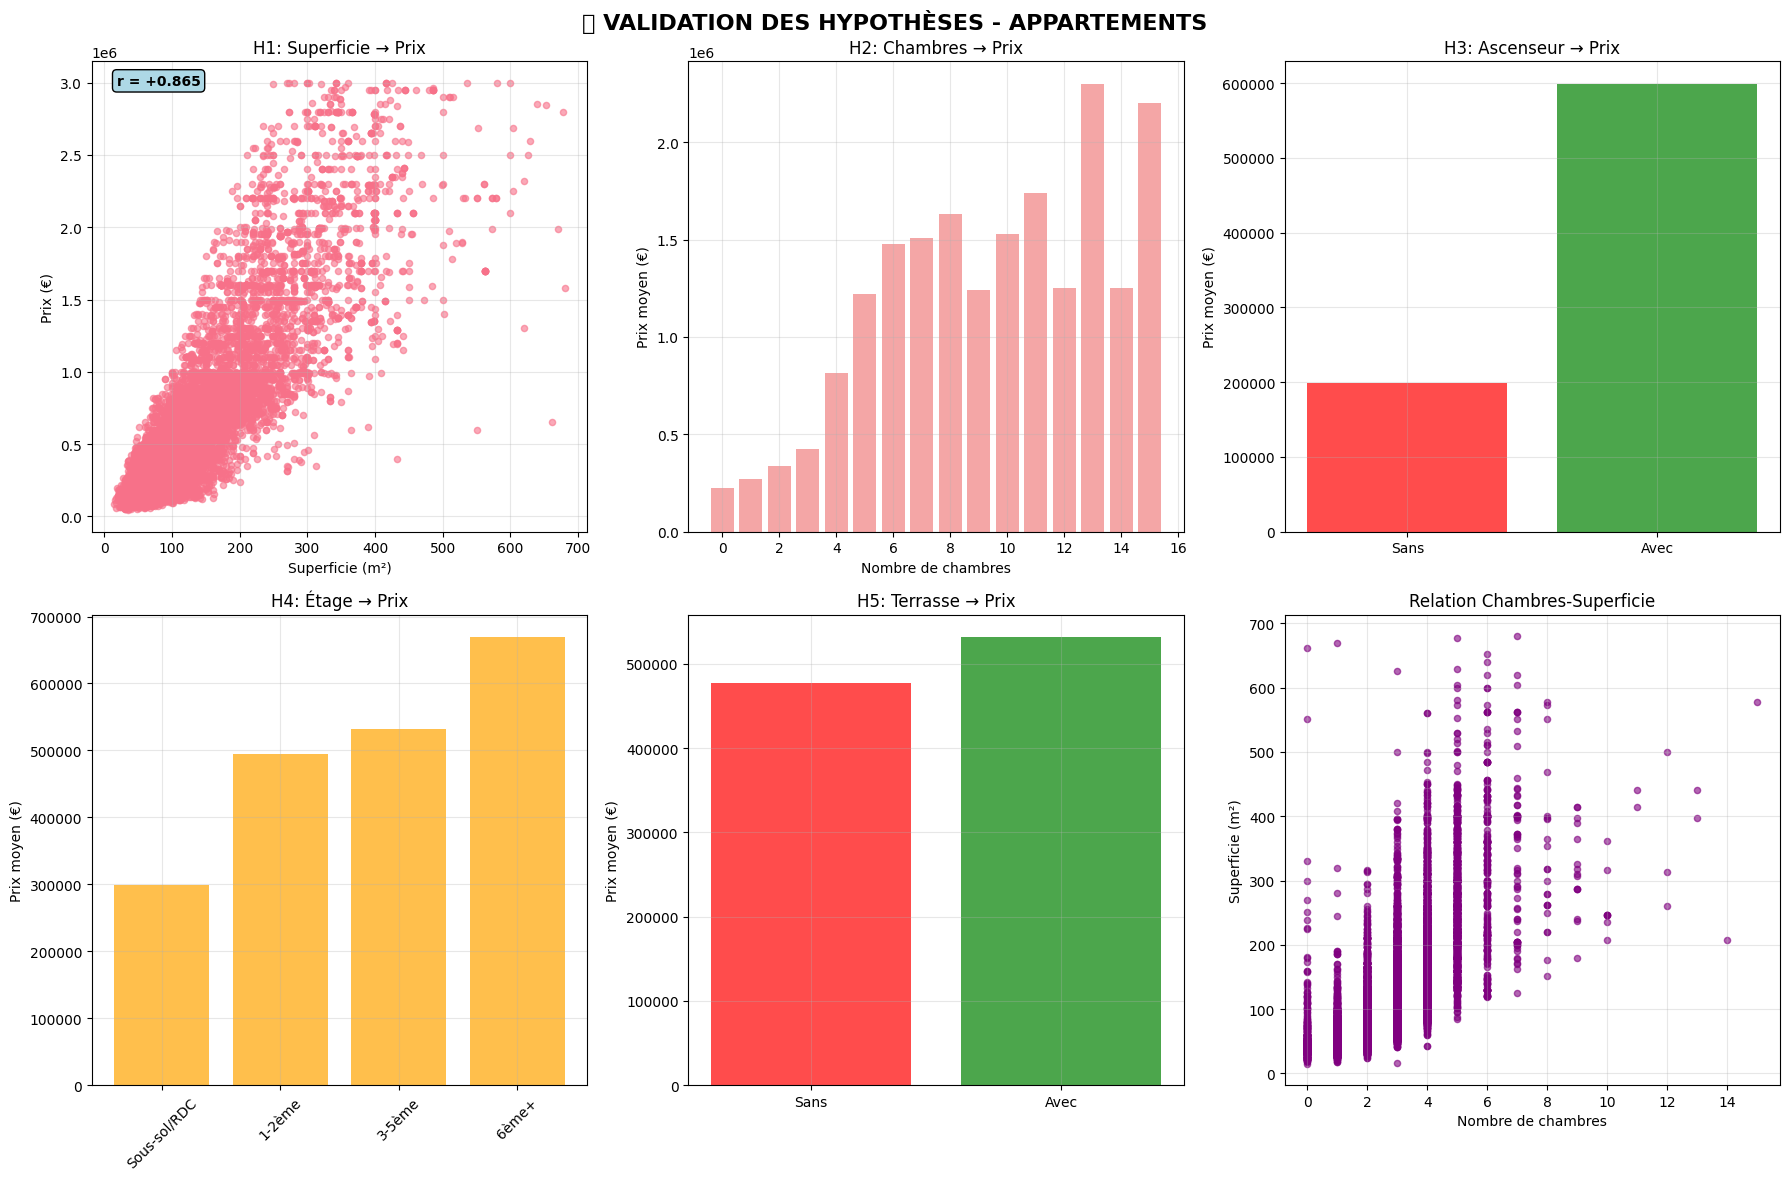


📋 RÉSUMÉ DE VALIDATION:
--------------------------------------------------
H1 - Superficie: ✅ CONFIRMÉE (r=+0.865)
H2 - Chambres: ✅ CONFIRMÉE (r=+0.520)
H3 - Ascenseur: ✅ CONFIRMÉE (+400,808€)
H4 - Étage: ✅ CONFIRMÉE (r=+0.167)
H5 - Terrasse: ✅ CONFIRMÉE (+53,818€)

📊 CONCLUSION: 18,923 appartements analysés

5. DISTRIBUTION DES PRIX
----------------------------------------


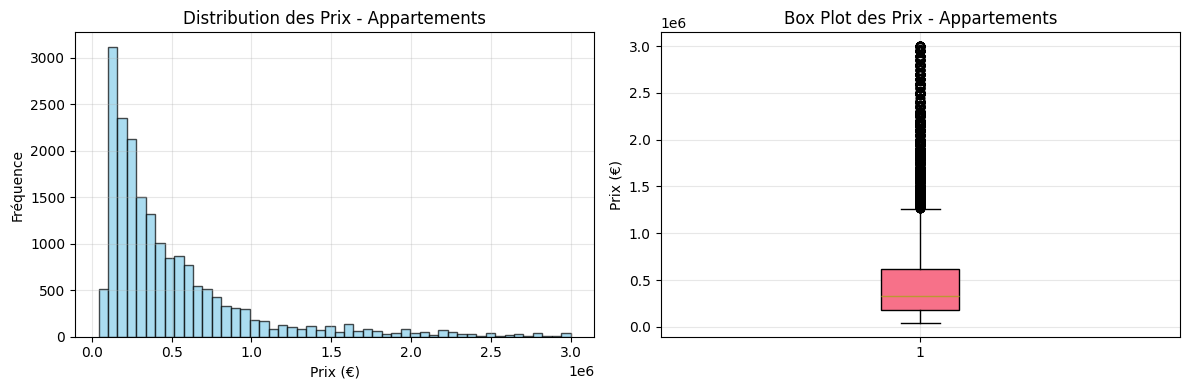

1er quartile (25%): 185,000 €
2ème quartile (50%): 330,000 €
3ème quartile (75%): 615,000 €

✅ Analyse des prix des appartements terminée!
📊 18,923 appartements analysés


In [28]:
# Analyse détaillée du prix par rapport aux variables - APPARTEMENTS SEULEMENT

print("ANALYSE DU PRIX PAR RAPPORT AUX VARIABLES - APPARTEMENTS")
print("="*60)

# 1. STATISTIQUES DESCRIPTIVES DU PRIX
print("\n1. STATISTIQUES DU PRIX DES APPARTEMENTS")
print("-" * 40)
prix_apt = df_appartements['buy_price']
print(f"Nombre d'appartements: {len(prix_apt):,}")
print(f"Prix moyen: {prix_apt.mean():,.0f} €")
print(f"Prix médian: {prix_apt.median():,.0f} €")
print(f"Prix min: {prix_apt.min():,.0f} €")
print(f"Prix max: {prix_apt.max():,.0f} €")
print(f"Écart-type: {prix_apt.std():,.0f} €")

# 2. CORRÉLATIONS PRIX VS VARIABLES IMPORTANTES
print("\n2. TOP 10 CORRÉLATIONS AVEC LE PRIX")
print("-" * 40)
# Variables numériques seulement
vars_num_apt = df_appartements.select_dtypes(include=[np.number]).columns.tolist()
vars_num_apt = [v for v in vars_num_apt if v != 'buy_price']

# Calculer les corrélations
correlations = []
for var in vars_num_apt:
    try:
        corr = df_appartements['buy_price'].corr(df_appartements[var])
        if not np.isnan(corr):
            correlations.append((var, corr))
    except:
        continue

# Trier par valeur absolue
correlations_sorted = sorted(correlations, key=lambda x: abs(x[1]), reverse=True)
print("Variables les plus corrélées au prix:")
for var, corr in correlations_sorted[:10]:
    if corr > 0.3:
        force = "FORTE +"
    elif corr > 0.1:
        force = "MODÉRÉE +"
    elif corr < -0.3:
        force = "FORTE -"
    elif corr < -0.1:
        force = "MODÉRÉE -"
    else:
        force = "FAIBLE"
    print(f"  {var:<20}: {corr:+.3f} ({force})")

# 3. GRAPHIQUES SCATTER POUR TOUTES LES VARIABLES SIGNIFICATIVES  
print("\n3. GRAPHIQUES PRIX vs TOUTES VARIABLES SIGNIFICATIVES")
print("-" * 40)

# Prendre TOUTES les variables avec corrélation > 0.2 (au lieu de seulement 6)
top_vars = [var for var, corr in correlations_sorted if abs(corr) > 0.2]

print(f"Visualisation de {len(top_vars)} variables avec corrélation > 0.2:")
for var, corr in correlations_sorted:
    if abs(corr) > 0.2:
        print(f"  • {var}: {corr:+.3f}")

if len(top_vars) > 0:
    # Calculer la grille optimale pour TOUTES les variables
    n_plots = len(top_vars)
    n_cols = 4  # 4 colonnes pour plus de graphiques par ligne
    n_rows = int(np.ceil(n_plots / n_cols))
    
    # Ajuster la taille selon le nombre de graphiques
    fig_width = 16  # Plus large pour 4 colonnes
    fig_height = n_rows * 3.5  # Un peu plus compact
    
    print(f"\nCréation d'une grille {n_rows}x{n_cols} pour {n_plots} graphiques")
    
    plt.figure(figsize=(fig_width, fig_height))
    
    for i, var in enumerate(top_vars):
        plt.subplot(n_rows, n_cols, i + 1)
        
        # Nettoyer les données
        data_clean = df_appartements[[var, 'buy_price']].dropna()
        
        if len(data_clean) > 10:  # Au moins 10 points pour un graphique valide
            plt.scatter(data_clean[var], data_clean['buy_price'], alpha=0.6, s=20, color='skyblue')
            plt.xlabel(var, fontsize=9)
            plt.ylabel('Prix (€)', fontsize=9)
            plt.title(f'Prix vs {var}', fontsize=10, fontweight='bold')
            
            # Afficher la corrélation avec couleur selon la force
            corr_val = data_clean[var].corr(data_clean['buy_price'])
            if abs(corr_val) > 0.5:
                color_box = 'red'
            elif abs(corr_val) > 0.3:
                color_box = 'orange'
            else:
                color_box = 'lightblue'
                
            plt.text(0.05, 0.95, f'r = {corr_val:+.3f}', transform=plt.gca().transAxes, 
                    bbox=dict(boxstyle="round,pad=0.3", facecolor=color_box, alpha=0.7),
                    fontsize=8, fontweight='bold')
            
            plt.grid(True, alpha=0.3)
            plt.tick_params(axis='both', which='major', labelsize=8)
        else:
            plt.text(0.5, 0.5, f'Pas assez\nde données\n({len(data_clean)} points)', 
                    ha='center', va='center', transform=plt.gca().transAxes,
                    fontsize=9, color='red')
            plt.title(f'{var} (Insuffisant)', fontsize=10, color='red')
    
    plt.tight_layout()
    plt.show()
    
    # TABLEAU RÉCAPITULATIF DE TOUTES LES CORRÉLATIONS
    print(f"\n📊 TABLEAU RÉCAPITULATIF - {len(top_vars)} VARIABLES SIGNIFICATIVES:")
    print("-" * 70)
    print(f"{'Variable':<25} {'Corrélation':<12} {'Force':<15} {'Type'}")
    print("-" * 70)
    
    for var, corr in correlations_sorted:
        if abs(corr) > 0.2:
            # Déterminer la force et le type
            if abs(corr) > 0.7:
                force = "TRÈS FORTE"
            elif abs(corr) > 0.5:
                force = "FORTE"
            elif abs(corr) > 0.3:
                force = "MODÉRÉE"
            else:
                force = "FAIBLE"
                
            type_corr = "POSITIVE" if corr > 0 else "NÉGATIVE"
            
            print(f"{var:<25} {corr:+.3f}       {force:<15} {type_corr}")
    
else:
    print("Aucune variable avec corrélation significative trouvée")

# 4. ANALYSE PAR CATÉGORIES
print("\n4. PRIX MOYEN PAR CATÉGORIES")
print("-" * 40)

# Analyse par nombre de chambres
if 'rooms' in df_appartements.columns:
    print("Prix moyen par nombre de chambres:")
    prix_par_chambres = df_appartements.groupby('rooms')['buy_price'].agg(['mean', 'count']).round(0)
    for chambres, stats in prix_par_chambres.iterrows():
        print(f"  {chambres} chambre(s): {stats['mean']:,.0f} € (n={stats['count']})")

print()

# Analyse par étage
if 'floor' in df_appartements.columns:
    print("Prix moyen par étage:")
    # Regrouper les étages pour une meilleure lisibilité
    df_appartements_temp = df_appartements.copy()
    df_appartements_temp['floor_group'] = pd.cut(df_appartements_temp['floor'], 
                                                bins=[-10, 0, 2, 5, 100], 
                                                labels=['Sous-sol/RDC', '1-2ème', '3-5ème', '6ème+'])

# 📊 VALIDATION DES HYPOTHÈSES - APPARTEMENTS
print("\n🔬 VALIDATION DES HYPOTHÈSES - APPARTEMENTS")
print("="*60)

plt.figure(figsize=(18, 12))

# H1: La superficie est le facteur #1 pour le prix
plt.subplot(2, 3, 1)
if 'sq_mt_built' in df_appartements.columns:
    plt.scatter(df_appartements['sq_mt_built'], df_appartements['buy_price'], alpha=0.6, s=20)
    plt.xlabel('Superficie (m²)')
    plt.ylabel('Prix (€)')
    plt.title('H1: Superficie → Prix')
    corr_h1 = df_appartements['sq_mt_built'].corr(df_appartements['buy_price'])
    plt.text(0.05, 0.95, f'r = {corr_h1:+.3f}', transform=plt.gca().transAxes, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor='lightblue'), fontweight='bold')
    plt.grid(True, alpha=0.3)

# H2: Le nombre de chambres influence le prix
plt.subplot(2, 3, 2)
if 'n_rooms' in df_appartements.columns:
    prix_par_chambres = df_appartements.groupby('n_rooms')['buy_price'].mean()
    plt.bar(prix_par_chambres.index, prix_par_chambres.values, color='lightcoral', alpha=0.7)
    plt.xlabel('Nombre de chambres')
    plt.ylabel('Prix moyen (€)')
    plt.title('H2: Chambres → Prix')
    plt.grid(True, alpha=0.3)

# H3: Présence d'ascenseur ajoute de la valeur
plt.subplot(2, 3, 3)
if 'has_lift' in df_appartements.columns:
    prix_ascenseur = df_appartements.groupby('has_lift')['buy_price'].mean()
    colors = ['red', 'green'] if len(prix_ascenseur) == 2 else ['blue']
    plt.bar(['Sans', 'Avec'], prix_ascenseur.values, color=colors, alpha=0.7)
    plt.ylabel('Prix moyen (€)')
    plt.title('H3: Ascenseur → Prix')
    plt.grid(True, alpha=0.3)

# H4: L'étage influence le prix
plt.subplot(2, 3, 4)
if 'floor' in df_appartements.columns:
    # Grouper les étages pour plus de clarté
    df_etages = df_appartements.copy()
    df_etages['floor_group'] = pd.cut(df_etages['floor'], 
                                    bins=[-10, 0, 2, 5, 15], 
                                    labels=['Sous-sol/RDC', '1-2ème', '3-5ème', '6ème+'])
    prix_etage = df_etages.groupby('floor_group', observed=True)['buy_price'].mean()
    plt.bar(range(len(prix_etage)), prix_etage.values, color='orange', alpha=0.7)
    plt.xticks(range(len(prix_etage)), prix_etage.index, rotation=45)
    plt.ylabel('Prix moyen (€)')
    plt.title('H4: Étage → Prix')
    plt.grid(True, alpha=0.3)

# H5: Balcon/Terrasse augmente le prix  
plt.subplot(2, 3, 5)
if 'has_terrace' in df_appartements.columns:
    prix_terrasse = df_appartements.groupby('has_terrace')['buy_price'].mean()
    colors = ['red', 'green'] if len(prix_terrasse) == 2 else ['blue']
    plt.bar(['Sans', 'Avec'], prix_terrasse.values, color=colors, alpha=0.7)
    plt.ylabel('Prix moyen (€)')
    plt.title('H5: Terrasse → Prix')
    plt.grid(True, alpha=0.3)

# Superficie vs Chambres (relation)
plt.subplot(2, 3, 6)
if 'sq_mt_built' in df_appartements.columns and 'n_rooms' in df_appartements.columns:
    plt.scatter(df_appartements['n_rooms'], df_appartements['sq_mt_built'], alpha=0.6, s=20, color='purple')
    plt.xlabel('Nombre de chambres')
    plt.ylabel('Superficie (m²)')
    plt.title('Relation Chambres-Superficie')
    plt.grid(True, alpha=0.3)

plt.suptitle('🏠 VALIDATION DES HYPOTHÈSES - APPARTEMENTS', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# 📋 RÉSUMÉ DES HYPOTHÈSES
print("\n📋 RÉSUMÉ DE VALIDATION:")
print("-" * 50)
if 'sq_mt_built' in df_appartements.columns:
    corr_superficie = df_appartements['sq_mt_built'].corr(df_appartements['buy_price'])
    print(f"H1 - Superficie: {'✅ CONFIRMÉE' if abs(corr_superficie) > 0.5 else '❌ REJETÉE'} (r={corr_superficie:+.3f})")

if 'n_rooms' in df_appartements.columns:
    corr_chambres = df_appartements['n_rooms'].corr(df_appartements['buy_price'])
    print(f"H2 - Chambres: {'✅ CONFIRMÉE' if abs(corr_chambres) > 0.3 else '❌ REJETÉE'} (r={corr_chambres:+.3f})")

if 'has_lift' in df_appartements.columns and len(df_appartements['has_lift'].unique()) > 1:
    prix_avec_sans = df_appartements.groupby('has_lift')['buy_price'].mean()
    diff_ascenseur = prix_avec_sans.iloc[1] - prix_avec_sans.iloc[0] if len(prix_avec_sans) == 2 else 0
    print(f"H3 - Ascenseur: {'✅ CONFIRMÉE' if diff_ascenseur > 5000 else '❌ REJETÉE'} (+{diff_ascenseur:,.0f}€)")

if 'floor' in df_appartements.columns:
    corr_etage = df_appartements['floor'].corr(df_appartements['buy_price'])
    print(f"H4 - Étage: {'✅ CONFIRMÉE' if corr_etage > 0.1 else '❌ REJETÉE'} (r={corr_etage:+.3f})")

if 'has_terrace' in df_appartements.columns and len(df_appartements['has_terrace'].unique()) > 1:
    prix_terrasse = df_appartements.groupby('has_terrace')['buy_price'].mean()
    diff_terrasse = prix_terrasse.iloc[1] - prix_terrasse.iloc[0] if len(prix_terrasse) == 2 else 0
    print(f"H5 - Terrasse: {'✅ CONFIRMÉE' if diff_terrasse > 3000 else '❌ REJETÉE'} (+{diff_terrasse:,.0f}€)")

print(f"\n📊 CONCLUSION: {df_appartements.shape[0]:,} appartements analysés")

# 5. DISTRIBUTION DES PRIX
print("\n5. DISTRIBUTION DES PRIX")
print("-" * 40)
plt.figure(figsize=(12, 4))

# Histogramme
plt.subplot(1, 2, 1)
plt.hist(df_appartements['buy_price'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Prix (€)')
plt.ylabel('Fréquence')
plt.title('Distribution des Prix - Appartements')
plt.grid(True, alpha=0.3)

# Box plot
plt.subplot(1, 2, 2)
plt.boxplot(df_appartements['buy_price'], vert=True, patch_artist=True)
plt.ylabel('Prix (€)')
plt.title('Box Plot des Prix - Appartements')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Quartiles
q1 = df_appartements['buy_price'].quantile(0.25)
q2 = df_appartements['buy_price'].quantile(0.50)  # médiane
q3 = df_appartements['buy_price'].quantile(0.75)

print(f"1er quartile (25%): {q1:,.0f} €")
print(f"2ème quartile (50%): {q2:,.0f} €") 
print(f"3ème quartile (75%): {q3:,.0f} €")

print(f"\n✅ Analyse des prix des appartements terminée!")
print(f"📊 {len(df_appartements):,} appartements analysés")   

DATASET MODÈLE - APPARTEMENTS
Variables sélectionnées : 6


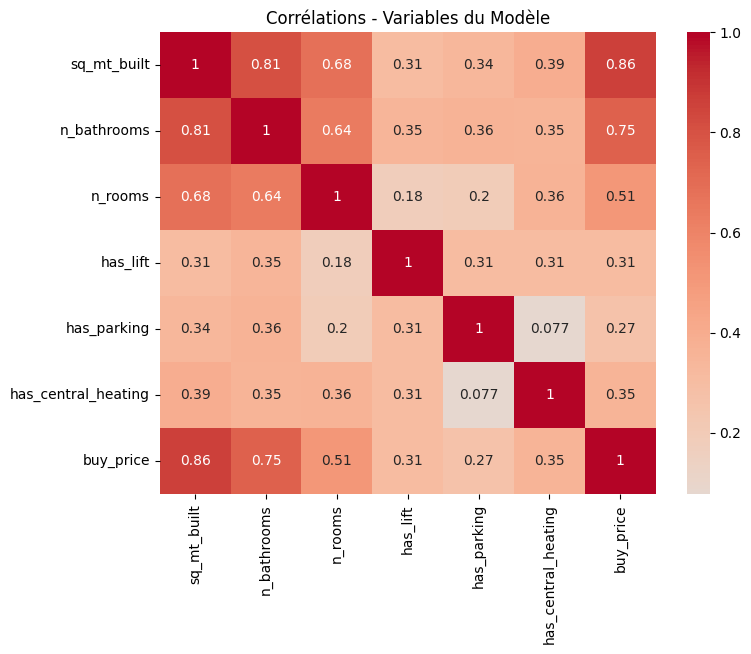

✅ Dataset prêt : (19125, 7)


In [ ]:
# 6. Dataset pour le modèle - Simple

print("DATASET MODÈLE - APPARTEMENTS")
print("="*40)


variables_model = [
    'sq_mt_built',      
    'n_bathrooms',       
    'n_rooms',           
    'has_lift',          
    'has_parking',       
    'has_central_heating', 
]

print(f"Variables sélectionnées : {len(variables_model)}")

# Créer le dataset modèle
df_appartements_model = df_appartements[variables_model + ['buy_price']].copy()

# Heatmap simple
plt.figure(figsize=(8, 6))
sns.heatmap(df_appartements_model.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Corrélations - Variables du Modèle')
plt.show()

print(f"✅ Dataset prêt : {df_appartements_model.shape}")

# Maison 

DATASET MODÈLE - MAISONS
Nombre de maisons: 2,617
Prix moyen: 1,546,121 €
Prix médian: 1,280,000 €
Prix min: 39,000 €
Prix max: 8,700,000 €

2. TOP 10 CORRÉLATIONS AVEC LE PRIX
----------------------------------------
Variables les plus corrélées au prix:
  sq_mt_built         : +0.759 (FORTE +)
  n_bathrooms         : +0.660 (FORTE +)
  rent_price          : -0.595 (FORTE -)
  n_rooms             : +0.575 (FORTE +)
  buy_price_by_area   : +0.490 (FORTE +)
  has_garden          : +0.353 (FORTE +)
  has_pool            : +0.317 (FORTE +)
  has_lift            : +0.266 (MODÉRÉE +)
  neighborhood        : -0.232 (MODÉRÉE -)
  has_parking         : +0.230 (MODÉRÉE +)

3. GRAPHIQUES PRIX vs TOUTES VARIABLES SIGNIFICATIVES
----------------------------------------
Visualisation de 10 variables avec corrélation > 0.2:
  • sq_mt_built: +0.759
  • n_bathrooms: +0.660
  • rent_price: -0.595
  • n_rooms: +0.575
  • buy_price_by_area: +0.490
  • has_garden: +0.353
  • has_pool: +0.317
  • has_lift:

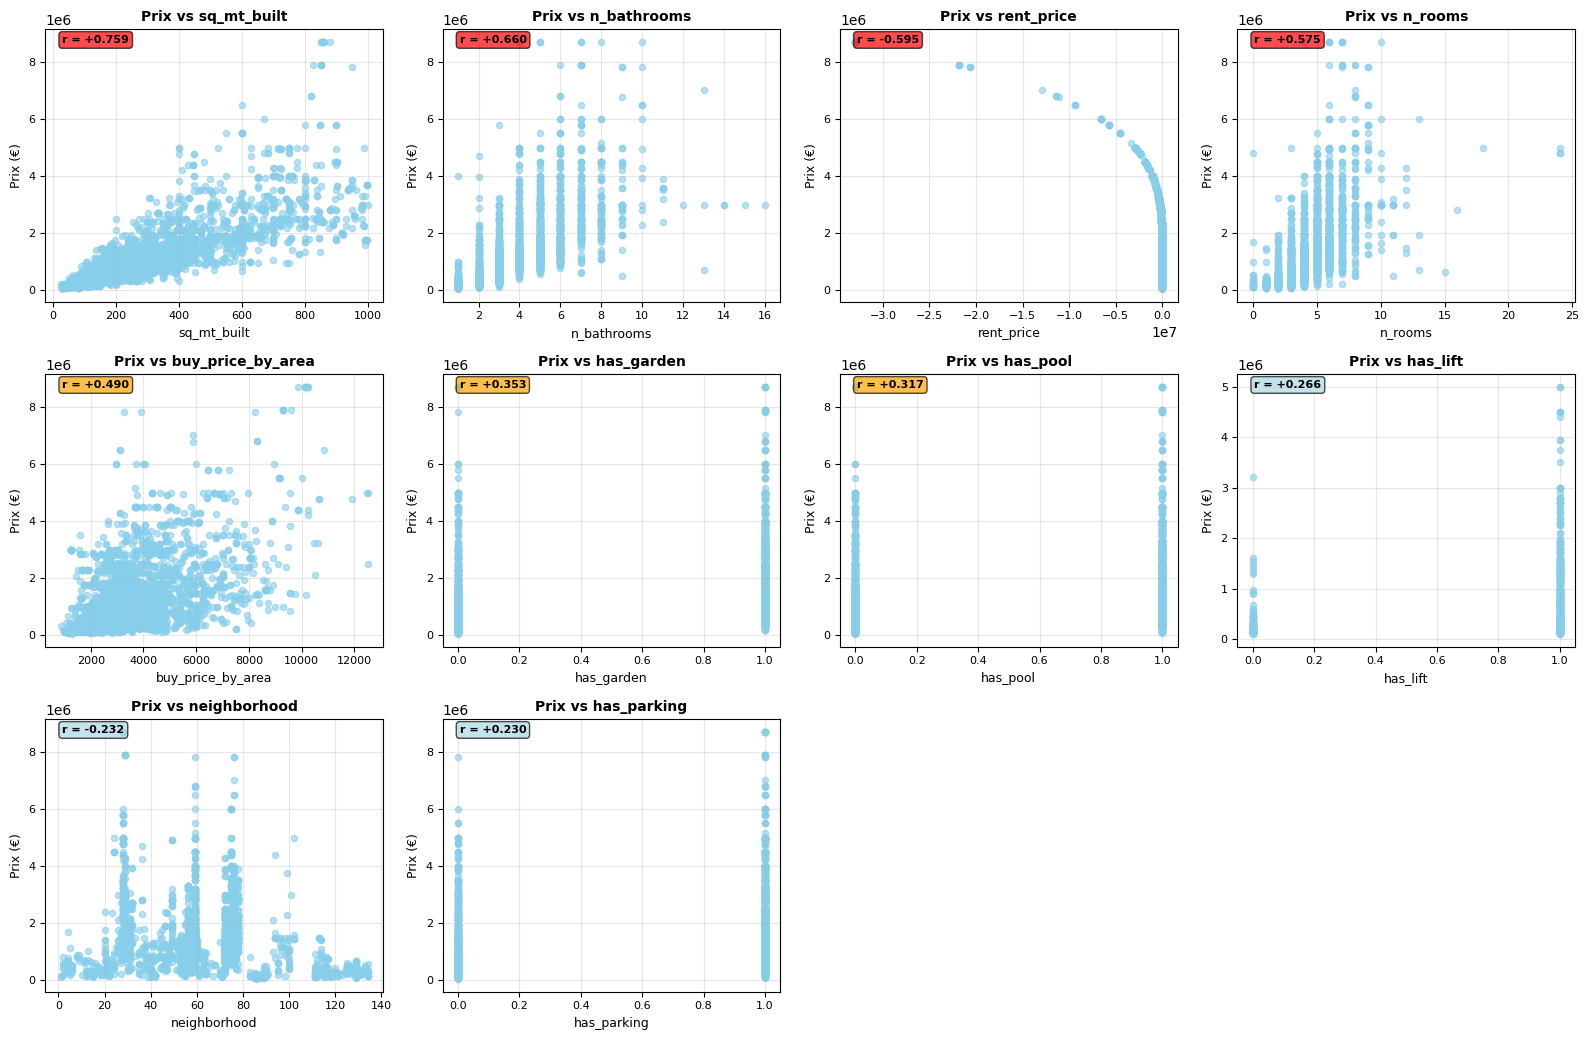


📊 TABLEAU RÉCAPITULATIF - 10 VARIABLES SIGNIFICATIVES:
----------------------------------------------------------------------
Variable                  Corrélation  Force           Type
----------------------------------------------------------------------
sq_mt_built               +0.759       TRÈS FORTE      POSITIVE
n_bathrooms               +0.660       FORTE           POSITIVE
rent_price                -0.595       FORTE           NÉGATIVE
n_rooms                   +0.575       FORTE           POSITIVE
buy_price_by_area         +0.490       MODÉRÉE         POSITIVE
has_garden                +0.353       MODÉRÉE         POSITIVE
has_pool                  +0.317       MODÉRÉE         POSITIVE
has_lift                  +0.266       FAIBLE          POSITIVE
neighborhood              -0.232       FAIBLE          NÉGATIVE
has_parking               +0.230       FAIBLE          POSITIVE

4. PRIX MOYEN PAR CATÉGORIES
----------------------------------------

Prix moyen par étage:
  Sous-s

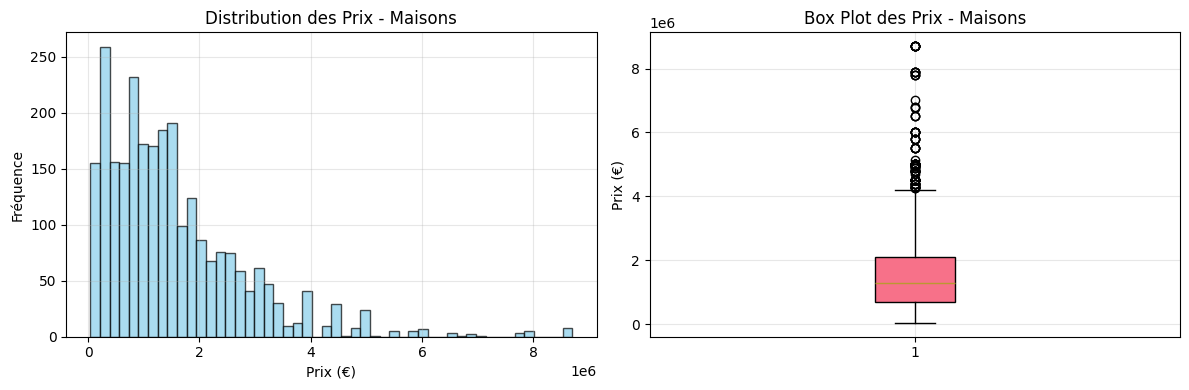

1er quartile (25%): 680,000 €
2ème quartile (50%): 1,280,000 €
3ème quartile (75%): 2,100,000 €


In [ ]:
# Dataset pour le modèle - Maisons

print("DATASET MODÈLE - MAISONS")
print("="*40)


# 2. TOP CORRÉLATIONS AVEC LE PRIX
vars_num_maisons = df_maisons.select_dtypes(include=[np.number]).columns.tolist()
vars_num_maisons = [v for v in vars_num_maisons if v != 'buy_price']

# Calculer les corrélations
correlations = []
for var in vars_num_maisons:
    try:
        corr = df_maisons['buy_price'].corr(df_maisons[var])
        if not np.isnan(corr):
            correlations.append((var, corr))
    except:
        continue

prix_maisons = df_maisons['buy_price']
print(f"Nombre de maisons: {len(prix_maisons):,}")
print(f"Prix moyen: {prix_maisons.mean():,.0f} €")
print(f"Prix médian: {prix_maisons.median():,.0f} €")
print(f"Prix min: {prix_maisons.min():,.0f} €")
print(f"Prix max: {prix_maisons.max():,.0f} €")


# 2. CORRÉLATIONS PRIX VS VARIABLES IMPORTANTES
print("\n2. TOP 10 CORRÉLATIONS AVEC LE PRIX")
print("-" * 40)
# Variables numériques seulement
vars_num_maisons = df_maisons.select_dtypes(include=[np.number]).columns.tolist()
vars_num_maisons = [v for v in vars_num_maisons if v != 'buy_price']

# Calculer les corrélations
correlations = []
for var in vars_num_apt:
    try:
        corr = df_maisons['buy_price'].corr(df_maisons[var])
        if not np.isnan(corr):
            correlations.append((var, corr))
    except:
        continue

# Trier par valeur absolue
correlations_sorted = sorted(correlations, key=lambda x: abs(x[1]), reverse=True)
print("Variables les plus corrélées au prix:")
for var, corr in correlations_sorted[:10]:
    if corr > 0.3:
        force = "FORTE +"
    elif corr > 0.1:
        force = "MODÉRÉE +"
    elif corr < -0.3:
        force = "FORTE -"
    elif corr < -0.1:
        force = "MODÉRÉE -"
    else:
        force = "FAIBLE"
    print(f"  {var:<20}: {corr:+.3f} ({force})")

# 3. GRAPHIQUES SCATTER POUR TOUTES LES VARIABLES SIGNIFICATIVES  
print("\n3. GRAPHIQUES PRIX vs TOUTES VARIABLES SIGNIFICATIVES")
print("-" * 40)

# Prendre TOUTES les variables avec corrélation > 0.2 (au lieu de seulement 6)
top_vars = [var for var, corr in correlations_sorted if abs(corr) > 0.2]

print(f"Visualisation de {len(top_vars)} variables avec corrélation > 0.2:")
for var, corr in correlations_sorted:
    if abs(corr) > 0.2:
        print(f"  • {var}: {corr:+.3f}")

if len(top_vars) > 0:
    # Calculer la grille optimale pour TOUTES les variables
    n_plots = len(top_vars)
    n_cols = 4  # 4 colonnes pour plus de graphiques par ligne
    n_rows = int(np.ceil(n_plots / n_cols))
    
    # Ajuster la taille selon le nombre de graphiques
    fig_width = 16  # Plus large pour 4 colonnes
    fig_height = n_rows * 3.5  # Un peu plus compact
    
    print(f"\nCréation d'une grille {n_rows}x{n_cols} pour {n_plots} graphiques")
    
    plt.figure(figsize=(fig_width, fig_height))
    
    for i, var in enumerate(top_vars):
        plt.subplot(n_rows, n_cols, i + 1)
        
        # Nettoyer les données
        data_clean = df_maisons[[var, 'buy_price']].dropna()
        
        if len(data_clean) > 10:  # Au moins 10 points pour un graphique valide
            plt.scatter(data_clean[var], data_clean['buy_price'], alpha=0.6, s=20, color='skyblue')
            plt.xlabel(var, fontsize=9)
            plt.ylabel('Prix (€)', fontsize=9)
            plt.title(f'Prix vs {var}', fontsize=10, fontweight='bold')
            
            # Afficher la corrélation avec couleur selon la force
            corr_val = data_clean[var].corr(data_clean['buy_price'])
            if abs(corr_val) > 0.5:
                color_box = 'red'
            elif abs(corr_val) > 0.3:
                color_box = 'orange'
            else:
                color_box = 'lightblue'
                
            plt.text(0.05, 0.95, f'r = {corr_val:+.3f}', transform=plt.gca().transAxes, 
                    bbox=dict(boxstyle="round,pad=0.3", facecolor=color_box, alpha=0.7),
                    fontsize=8, fontweight='bold')
            
            plt.grid(True, alpha=0.3)
            plt.tick_params(axis='both', which='major', labelsize=8)
        else:
            plt.text(0.5, 0.5, f'Pas assez\nde données\n({len(data_clean)} points)', 
                    ha='center', va='center', transform=plt.gca().transAxes,
                    fontsize=9, color='red')
            plt.title(f'{var} (Insuffisant)', fontsize=10, color='red')
    
    plt.tight_layout()
    plt.show()
    
    # TABLEAU RÉCAPITULATIF DE TOUTES LES CORRÉLATIONS
    print(f"\n📊 TABLEAU RÉCAPITULATIF - {len(top_vars)} VARIABLES SIGNIFICATIVES:")
    print("-" * 70)
    print(f"{'Variable':<25} {'Corrélation':<12} {'Force':<15} {'Type'}")
    print("-" * 70)
    
    for var, corr in correlations_sorted:
        if abs(corr) > 0.2:
            # Déterminer la force et le type
            if abs(corr) > 0.7:
                force = "TRÈS FORTE"
            elif abs(corr) > 0.5:
                force = "FORTE"
            elif abs(corr) > 0.3:
                force = "MODÉRÉE"
            else:
                force = "FAIBLE"
                
            type_corr = "POSITIVE" if corr > 0 else "NÉGATIVE"
            
            print(f"{var:<25} {corr:+.3f}       {force:<15} {type_corr}")
    
else:
    print("Aucune variable avec corrélation significative trouvée")

# 4. ANALYSE PAR CATÉGORIES
print("\n4. PRIX MOYEN PAR CATÉGORIES")
print("-" * 40)

# Analyse par nombre de chambres
if 'rooms' in df_maisons.columns:
    print("Prix moyen par nombre de chambres:")
    prix_par_chambres = df_maisons.groupby('rooms')['buy_price'].agg(['mean', 'count']).round(0)
    for chambres, stats in prix_par_chambres.iterrows():
        print(f"  {chambres} chambre(s): {stats['mean']:,.0f} € (n={stats['count']})")

print()

# Analyse par étage
if 'floor' in df_maisons.columns:
    print("Prix moyen par étage:")
    # Regrouper les étages pour une meilleure lisibilité
    df_maisons_temp = df_maisons.copy()
    df_maisons_temp['floor_group'] = pd.cut(df_maisons_temp['floor'], 
                                                bins=[-10, 0, 2, 5, 100], 
                                                labels=['Sous-sol/RDC', '1-2ème', '3-5ème', '6ème+'])
    
    prix_par_etage = df_maisons_temp.groupby('floor_group', observed=True)['buy_price'].agg(['mean', 'count']).round(0)
    for etage, stats in prix_par_etage.iterrows():
        print(f"  {etage}: {stats['mean']:,.0f} € (n={stats['count']})")

# 5. DISTRIBUTION DES PRIX
print("\n5. DISTRIBUTION DES PRIX")
print("-" * 40)
plt.figure(figsize=(12, 4))

# Histogramme
plt.subplot(1, 2, 1)
plt.hist(df_maisons['buy_price'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Prix (€)')
plt.ylabel('Fréquence')
plt.title('Distribution des Prix - Maisons')
plt.grid(True, alpha=0.3)

# Box plot
plt.subplot(1, 2, 2)
plt.boxplot(df_maisons['buy_price'], vert=True, patch_artist=True)
plt.ylabel('Prix (€)')
plt.title('Box Plot des Prix - Maisons')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Quartiles
q1 = df_maisons['buy_price'].quantile(0.25)
q2 = df_maisons['buy_price'].quantile(0.50)  # médiane
q3 = df_maisons['buy_price'].quantile(0.75)
print(f"1er quartile (25%): {q1:,.0f} €")
print(f"2ème quartile (50%): {q2:,.0f} €") 
print(f"3ème quartile (75%): {q3:,.0f} €")

# 📊 VALIDATION DES HYPOTHÈSES - MAISONS
print("\n🔬 VALIDATION DES HYPOTHÈSES - MAISONS")
print("="*60)

plt.figure(figsize=(18, 12))

# H1: La superficie totale est cruciale
plt.subplot(2, 3, 1)
if 'sq_mt_built' in df_maisons.columns:
    plt.scatter(df_maisons['sq_mt_built'], df_maisons['buy_price'], alpha=0.6, s=20, color='darkgreen')
    plt.xlabel('Superficie (m²)')
    plt.ylabel('Prix (€)')
    plt.title('H1: Superficie → Prix')
    corr_h1 = df_maisons['sq_mt_built'].corr(df_maisons['buy_price'])
    plt.text(0.05, 0.95, f'r = {corr_h1:+.3f}', transform=plt.gca().transAxes, 
             bbox=dict(boxstyle="round,pad=0.3", facecolor='lightgreen'), fontweight='bold')
    plt.grid(True, alpha=0.3)

# H2: Chambres et salles de bain importantes
plt.subplot(2, 3, 2)
if 'n_rooms' in df_maisons.columns and 'n_bathrooms' in df_maisons.columns:
    # Scatter plot chambres vs prix avec couleur selon nb salles de bain
    scatter = plt.scatter(df_maisons['n_rooms'], df_maisons['buy_price'], 
                         c=df_maisons['n_bathrooms'], alpha=0.6, s=30, cmap='viridis')
    plt.xlabel('Nombre de chambres')
    plt.ylabel('Prix (€)')
    plt.title('H2: Chambres + Bains → Prix')
    plt.colorbar(scatter, label='Nb SdB')
    plt.grid(True, alpha=0.3)

# H3: Présence de jardin impacte le prix
plt.subplot(2, 3, 3)
if 'has_garden' in df_maisons.columns:
    prix_jardin = df_maisons.groupby('has_garden')['buy_price'].mean()
    colors = ['red', 'green'] if len(prix_jardin) == 2 else ['blue']
    plt.bar(['Sans jardin', 'Avec jardin'], prix_jardin.values, color=colors, alpha=0.7)
    plt.ylabel('Prix moyen (€)')
    plt.title('H3: Jardin → Prix')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

# H4: Piscine impacte le prix
plt.subplot(2, 3, 4)
if 'has_pool' in df_maisons.columns:
    prix_piscine = df_maisons.groupby('has_pool')['buy_price'].mean()
    colors = ['red', 'blue'] if len(prix_piscine) == 2 else ['blue']
    plt.bar(['Sans piscine', 'Avec piscine'], prix_piscine.values, color=colors, alpha=0.7)
    plt.ylabel('Prix moyen (€)')
    plt.title('H4: Piscine → Prix')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

# H5: Parking/Garage est essentiel
plt.subplot(2, 3, 5)
if 'has_parking' in df_maisons.columns:
    prix_parking = df_maisons.groupby('has_parking')['buy_price'].mean()
    colors = ['red', 'orange'] if len(prix_parking) == 2 else ['blue']
    plt.bar(['Sans parking', 'Avec parking'], prix_parking.values, color=colors, alpha=0.7)
    plt.ylabel('Prix moyen (€)')
    plt.title('H5: Parking → Prix')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)

# Relation Superficie vs Nombre total de pièces
plt.subplot(2, 3, 6)
if 'sq_mt_built' in df_maisons.columns and 'n_rooms' in df_maisons.columns:
    # Calculer total pièces (chambres + salles de bain si disponible)
    total_pieces = df_maisons['n_rooms']
    if 'n_bathrooms' in df_maisons.columns:
        total_pieces = df_maisons['n_rooms'] + df_maisons['n_bathrooms']
    
    plt.scatter(total_pieces, df_maisons['sq_mt_built'], alpha=0.6, s=20, color='brown')
    plt.xlabel('Total pièces')
    plt.ylabel('Superficie (m²)')
    plt.title('Relation Pièces-Superficie')
    plt.grid(True, alpha=0.3)

plt.suptitle('🏡 VALIDATION DES HYPOTHÈSES - MAISONS', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# 📋 RÉSUMÉ DES HYPOTHÈSES
print("\n📋 RÉSUMÉ DE VALIDATION:")
print("-" * 50)
if 'sq_mt_built' in df_maisons.columns:
    corr_superficie = df_maisons['sq_mt_built'].corr(df_maisons['buy_price'])
    print(f"H1 - Superficie: {'✅ CONFIRMÉE' if abs(corr_superficie) > 0.5 else '❌ REJETÉE'} (r={corr_superficie:+.3f})")

if 'n_rooms' in df_maisons.columns:
    corr_chambres = df_maisons['n_rooms'].corr(df_maisons['buy_price'])
    print(f"H2 - Chambres/SdB: {'✅ CONFIRMÉE' if abs(corr_chambres) > 0.3 else '❌ REJETÉE'} (r={corr_chambres:+.3f})")

if 'has_garden' in df_maisons.columns and len(df_maisons['has_garden'].unique()) > 1:
    prix_avec_sans = df_maisons.groupby('has_garden')['buy_price'].mean()
    diff_jardin = prix_avec_sans.iloc[1] - prix_avec_sans.iloc[0] if len(prix_avec_sans) == 2 else 0
    print(f"H3 - Jardin: {'✅ CONFIRMÉE' if diff_jardin > 10000 else '❌ REJETÉE'} (+{diff_jardin:,.0f}€)")

if 'has_pool' in df_maisons.columns and len(df_maisons['has_pool'].unique()) > 1:
    prix_piscine = df_maisons.groupby('has_pool')['buy_price'].mean()
    diff_piscine = prix_piscine.iloc[1] - prix_piscine.iloc[0] if len(prix_piscine) == 2 else 0
    print(f"H4 - Piscine: {'✅ CONFIRMÉE' if diff_piscine > 15000 else '❌ REJETÉE'} (+{diff_piscine:,.0f}€)")

if 'has_parking' in df_maisons.columns and len(df_maisons['has_parking'].unique()) > 1:
    prix_parking = df_maisons.groupby('has_parking')['buy_price'].mean()
    diff_parking = prix_parking.iloc[1] - prix_parking.iloc[0] if len(prix_parking) == 2 else 0
    print(f"H5 - Parking: {'✅ CONFIRMÉE' if diff_parking > 8000 else '❌ REJETÉE'} (+{diff_parking:,.0f}€)")

print(f"\n📊 CONCLUSION: {df_maisons.shape[0]:,} maisons analysées")
   

DATASET MODÈLE - MAISONS
Variables sélectionnées : 8


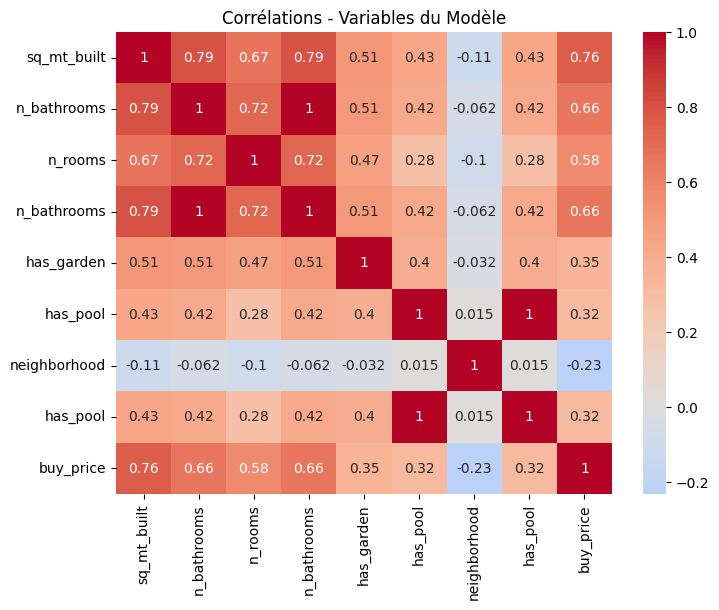

 Dataset prêt : (2617, 9)


In [ ]:
# 6. Dataset pour le modèle - Simple

print("DATASET MODÈLE - MAISONS")
print("="*40)

# Variables importantes 
variables_model = [
    'sq_mt_built',
    'n_bathrooms',
    'n_rooms',      
    'n_bathrooms',
    'has_garden',
    'has_pool',
    'neighborhood', 
    'has_pool'
]

print(f"Variables sélectionnées : {len(variables_model)}")

# Créer le dataset modèle
df_maisons_model = df_maisons[variables_model + ['buy_price']].copy()

# Heatmap simple
plt.figure(figsize=(8, 6))
sns.heatmap(df_maisons_model.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Corrélations - Variables du Modèle')
plt.show()

print(f" Dataset prêt : {df_maisons_model.shape}")

In [ ]:
df_appartements_model.to_csv('df_appartements_model.csv', index=False)  
df_maisons_model.to_csv('df_maisons_model.csv', index=False)